In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import time, copy
from sklearn.utils.class_weight import compute_class_weight

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_dir = '/content/drive/MyDrive/DLAProject/data/train'
val_dir   = '/content/drive/MyDrive/DLAProject/data/val'
test_dir  = '/content/drive/MyDrive/DLAProject/data/test'


Using device: cpu


In [ ]:
def convert_rgba_to_rgb(img):
    return img.convert("RGBA").convert("RGB")

data_transforms = {
    'train': transforms.Compose([
        transforms.Lambda(convert_rgba_to_rgb),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.1, 2.0))], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Lambda(convert_rgba_to_rgb),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Lambda(convert_rgba_to_rgb),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Create datasets
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset   = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset  = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# Create dataloaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

class_labels = train_dataset.classes
print("Class labels:", class_labels)

Class labels: ['basking', 'blacktip', 'blue', 'bull', 'hammerhead', 'lemon', 'mako', 'nurse', 'sand tiger', 'thresher', 'tiger', 'whale', 'white', 'whitetip']


In [ ]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
num_classes = len(class_labels)
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)


try:
    state_dict_phase1 = torch.load("/content/drive/MyDrive/model_phase1_3class.pth", map_location=device, weights_only=True)
except TypeError:
    state_dict_phase1 = torch.load("model_phase1_3class.pth", map_location=device)

state_dict_phase1.pop('fc.weight', None)
state_dict_phase1.pop('fc.bias', None)
model.load_state_dict(state_dict_phase1, strict=False)


_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=[])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
targets = np.array(train_dataset.targets)
classes = np.unique(targets)
class_weights_np = compute_class_weight(class_weight='balanced', classes=classes, y=targets)
class_weights = torch.FloatTensor(class_weights_np).to(device)
print("Computed class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam([
    {"params": model.fc.parameters(), "lr": 1e-3},
    {"params": [param for name, param in model.named_parameters() if "fc" not in name], "lr": 1e-4}
], weight_decay=1e-4)

steps_per_epoch = len(train_loader)
num_epochs = 50
total_steps = steps_per_epoch * num_epochs
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=[1e-3, 1e-4],
    total_steps=total_steps,
    pct_start=0.3,
    anneal_strategy='cos',
    cycle_momentum=False
)

Computed class weights: tensor([1.1931, 0.9702, 1.0387, 1.0148, 0.8741, 0.9293, 1.1036, 1.4014, 1.1466,
        0.9392, 1.1466, 0.8408, 0.8251, 0.8829])


In [ ]:
train_losses = []
val_losses = []

def train_model_onecycle(model, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        train_losses.append(epoch_loss)

        model.eval()
        running_loss_val = 0.0
        running_corrects_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                running_loss_val += loss.item() * inputs.size(0)
                running_corrects_val += torch.sum(preds == labels.data)

        epoch_loss_val = running_loss_val / len(val_dataset)
        epoch_acc_val = running_corrects_val.double() / len(val_dataset)
        val_losses.append(epoch_loss_val)

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print(f"Val Loss:   {epoch_loss_val:.4f} Acc: {epoch_acc_val:.4f}")

        if epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f"Training complete. Best Val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model

model = train_model_onecycle(model, criterion, optimizer, scheduler, num_epochs)

# Plot training and validation losses
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.show()

Epoch 1/50
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.5666 Acc: 0.1489
Val Loss:   2.3660 Acc: 0.3041

Epoch 2/50
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.3217 Acc: 0.2937
Val Loss:   2.0623 Acc: 0.4122

Epoch 3/50
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.0886 Acc: 0.3430
Val Loss:   1.7476 Acc: 0.5473

Epoch 4/50
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.pause(0.001)

def plot_sample_predictions(model, test_loader, class_labels, num_samples=9):
    model.eval()
    # Get one batch from test loader
    inputs, labels = next(iter(test_loader))
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1)

    # Bring tensors to CPU for plotting
    inputs = inputs.cpu()
    probs = probs.cpu().numpy()
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    plt.figure(figsize=(15, 15))
    for i in range(min(num_samples, inputs.size(0))):
        ax = plt.subplot(3, 3, i + 1)
        imshow(inputs[i])
        true_class = class_labels[labels[i]]
        pred_class = class_labels[preds[i]]
        confidence = probs[i][preds[i]] * 100
        ax.set_title(f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%", fontsize=10)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

plot_sample_predictions(model, test_loader, class_labels)


Full dataset classes (14): ['basking', 'blacktip', 'blue', 'bull', 'hammerhead', 'lemon', 'mako', 'nurse', 'sand tiger', 'thresher', 'tiger', 'whale', 'white', 'whitetip']


<ipython-input-15-13dab496df97>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict_phase1 = torch.load("model_phase1_3class.pth", map_location=device)


Computed class weights: tensor([1.1931, 0.9702, 1.0387, 1.0148, 0.8741, 0.9293, 1.1036, 1.4014, 1.1466,
        0.9392, 1.1466, 0.8408, 0.8251, 0.8829], device='cuda:0')
Starting Phase 2 Training on full dataset...
Epoch 1/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 2.0205 Acc: 0.3350
val Loss: 1.3751 Acc: 0.5338

Epoch 2/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 1.4475 Acc: 0.5243
val Loss: 0.9678 Acc: 0.6554

Epoch 3/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 1.1970 Acc: 0.6125
val Loss: 1.0185 Acc: 0.6486

Epoch 4/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 1.0972 Acc: 0.6408
val Loss: 0.7322 Acc: 0.7432

Epoch 5/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.9145 Acc: 0.7063
val Loss: 0.5546 Acc: 0.8176

Epoch 6/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.7837 Acc: 0.7395
val Loss: 0.5429 Acc: 0.8176

Epoch 7/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.7029 Acc: 0.7694
val Loss: 0.3487 Acc: 0.8784

Epoch 8/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.6410 Acc: 0.7880
val Loss: 0.4352 Acc: 0.8581

Epoch 9/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.5915 Acc: 0.8083
val Loss: 0.4834 Acc: 0.8176

Epoch 10/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.5205 Acc: 0.8285
val Loss: 0.3791 Acc: 0.8784

Epoch 11/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.5203 Acc: 0.8341
val Loss: 0.3584 Acc: 0.8649

Epoch 12/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4454 Acc: 0.8633
val Loss: 0.3287 Acc: 0.9054

Epoch 13/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4600 Acc: 0.8568
val Loss: 0.3131 Acc: 0.8649

Epoch 14/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.3477 Acc: 0.8883
val Loss: 0.2994 Acc: 0.8851

Epoch 15/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.3472 Acc: 0.8924
val Loss: 0.2621 Acc: 0.9054

Epoch 16/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.3130 Acc: 0.9029
val Loss: 0.2692 Acc: 0.8986

Epoch 17/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.3234 Acc: 0.9037
val Loss: 0.2720 Acc: 0.8851

Epoch 18/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.2936 Acc: 0.9086
val Loss: 0.2595 Acc: 0.8851

Epoch 19/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.3218 Acc: 0.9013
val Loss: 0.2639 Acc: 0.8851

Epoch 20/20
----------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.3106 Acc: 0.9086
val Loss: 0.2504 Acc: 0.8784

Training complete in 15m 25s
Best val Acc: 0.9054
Phase 2 training complete and model saved as 'model_phase2_full_V1.pth'.


Test Classification Report:
              precision    recall  f1-score   support

     basking       0.91      1.00      0.95        10
    blacktip       0.82      0.75      0.78        12
        blue       0.85      0.92      0.88        12
        bull       0.67      0.73      0.70        11
  hammerhead       1.00      0.86      0.92        14
       lemon       0.90      0.69      0.78        13
        mako       0.83      0.91      0.87        11
       nurse       1.00      1.00      1.00         8
  sand tiger       0.77      0.91      0.83        11
    thresher       1.00      0.92      0.96        13
       tiger       0.77      0.91      0.83        11
       whale       1.00      0.93      0.96        14
       white       0.93      1.00      0.97        14
    whitetip       0.92      0.85      0.88        13

    accuracy                           0.88       167
   macro avg       0.88      0.88      0.88       167
weighted avg       0.89      0.88      0.88       16

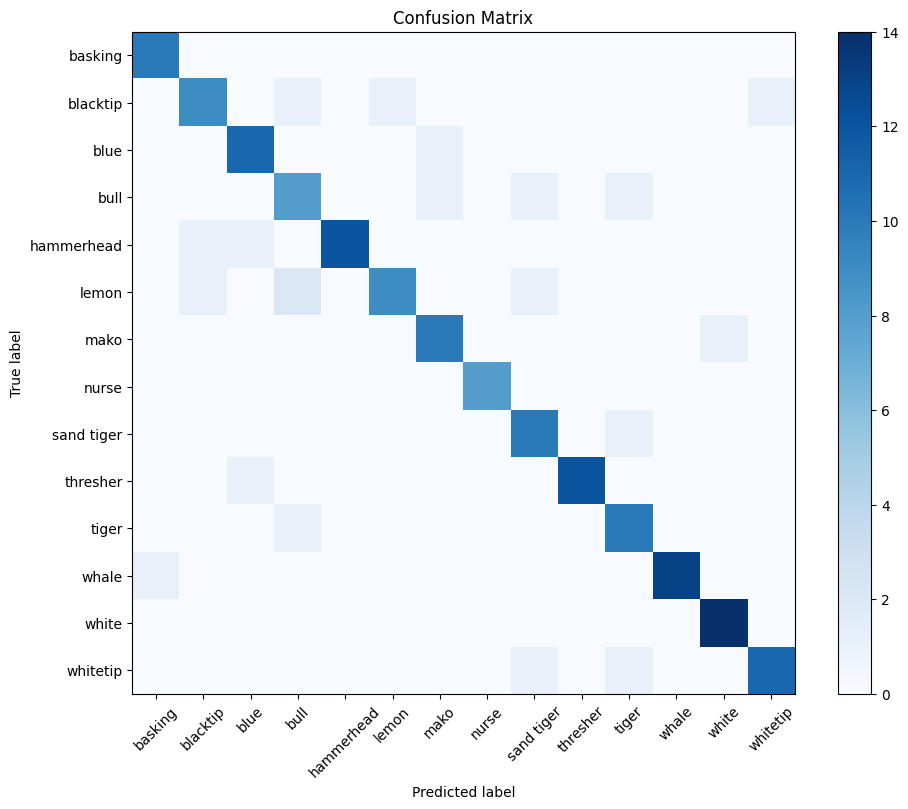

In [ ]:
model_phase2.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader_full:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_phase2(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print("Test Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset_full.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(num_full_classes)
plt.xticks(tick_marks, train_dataset_full.classes, rotation=45)
plt.yticks(tick_marks, train_dataset_full.classes)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
image_path='/content/drive/MyDrive/DLAProject/data/test/blue/00000003.jpg'
def predict_image(image_path, model, device, transform, class_names):
    """
    Load an image, apply transforms, and print the predicted class.
    """
    from PIL import Image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    print("Predicted class:", class_names[preds.item()])
